In [51]:
# Cell 1: Imports & Global Settings
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import networkx as nx
import math
import itertools
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

# Ensure consistent fonts and sizes for all plots
plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})


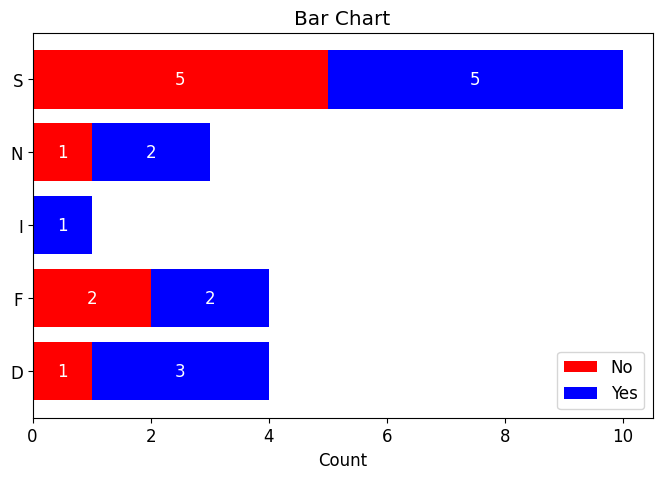

In [52]:
df_bar = pd.read_csv("bar_assignment.csv")

# Transform 1 → "Yes" and 0 → "No"
df_bar['Response'] = df_bar['COUNT'].map({1: 'Yes', 0: 'No'})

# Create a frequency table for each LABEL
bar_counts = pd.crosstab(df_bar['LABEL'], df_bar['Response'])

# Create the plot
plt.figure(figsize=(8, 5))

# Plot the "No" portion (red) on the left
bars_no = plt.barh(bar_counts.index, bar_counts['No'], color='red', label='No')
# Plot the "Yes" portion (blue) on the right (stacked to the right of "No")
bars_yes = plt.barh(bar_counts.index, bar_counts['Yes'], left=bar_counts['No'], color='blue', label='Yes')

# Set labels and title
plt.xlabel("Count")
plt.title("Bar Chart")
plt.legend(loc='lower right')

# Annotate each bar segment with its count value
# Annotate the "No" bars (red)
for bar in bars_no:
    width = bar.get_width()
    if width > 0:
        # Center annotation within the red segment
        x = bar.get_x() + width / 2.0
        y = bar.get_y() + bar.get_height() / 2.0
        plt.text(x, y, f"{int(width)}", va='center', ha='center', color='white', fontsize=12)

# Annotate the "Yes" bars (blue)
for bar in bars_yes:
    width = bar.get_width()
    if width > 0:
        # Center annotation within the blue segment
        x = bar.get_x() + width / 2.0
        y = bar.get_y() + bar.get_height() / 2.0
        plt.text(x, y, f"{int(width)}", va='center', ha='center', color='white', fontsize=12)

plt.show()


In [53]:
df_sankey = pd.read_csv("sankey_assignment.csv")
df_sankey.set_index("LABEL", inplace=True)

# Reorder rows to the desired order: D, F, I, N, S
desired_order = ['D', 'F', 'I', 'N', 'S']
df_sankey = df_sankey.reindex(desired_order)

# Define node groups
left_nodes   = ['PS', 'OMP', 'CNP', 'NRP', 'NMCCC', 'PEC', 'NCDM', 'RGS']
middle_nodes = desired_order  # ['D', 'F', 'I', 'N', 'S']
right_nodes  = ['Reg', 'Aca', 'Oth']
all_nodes = left_nodes + middle_nodes + right_nodes

# Create mapping from node label to index (for Plotly)
node_index = {node: idx for idx, node in enumerate(all_nodes)}

# Build lists for Sankey diagram links
sankey_sources = []
sankey_targets = []
sankey_values  = []

# Build links from left nodes to the middle nodes,
# then from the middle nodes to the right nodes.
for mid in middle_nodes:
    # Links from left nodes to the middle node
    for left in left_nodes:
        value = df_sankey.loc[mid, left]
        if pd.notna(value) and value > 0:
            sankey_sources.append(node_index[left])
            sankey_targets.append(node_index[mid])
            sankey_values.append(value)
    # Links from the middle node to right nodes
    for right in right_nodes:
        value = df_sankey.loc[mid, right]
        if pd.notna(value) and value > 0:
            sankey_sources.append(node_index[mid])
            sankey_targets.append(node_index[right])
            sankey_values.append(value)

color_palette = px.colors.qualitative.Pastel

# Ensure we have enough colors for all nodes; cycle through if necessary.
num_nodes = len(all_nodes)
node_colors = [color_palette[i % len(color_palette)] for i in range(num_nodes)]

# Create a dictionary mapping each node to its pastel color.
node_color_dict = {node: node_colors[i] for i, node in enumerate(all_nodes)}

# Now, assign each link the color of its source node.
link_colors = [node_color_dict[all_nodes[src]] for src in sankey_sources]

# Create the Plotly Sankey Diagram with custom pastel node and link colors
sankey_fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_nodes,
        color=node_colors
    ),
    link=dict(
        source=sankey_sources,
        target=sankey_targets,
        value=sankey_values,
        color=link_colors
    )
)])

sankey_fig.update_layout(title_text="Sankey Diagram", font=dict(size=12))
sankey_fig.show()



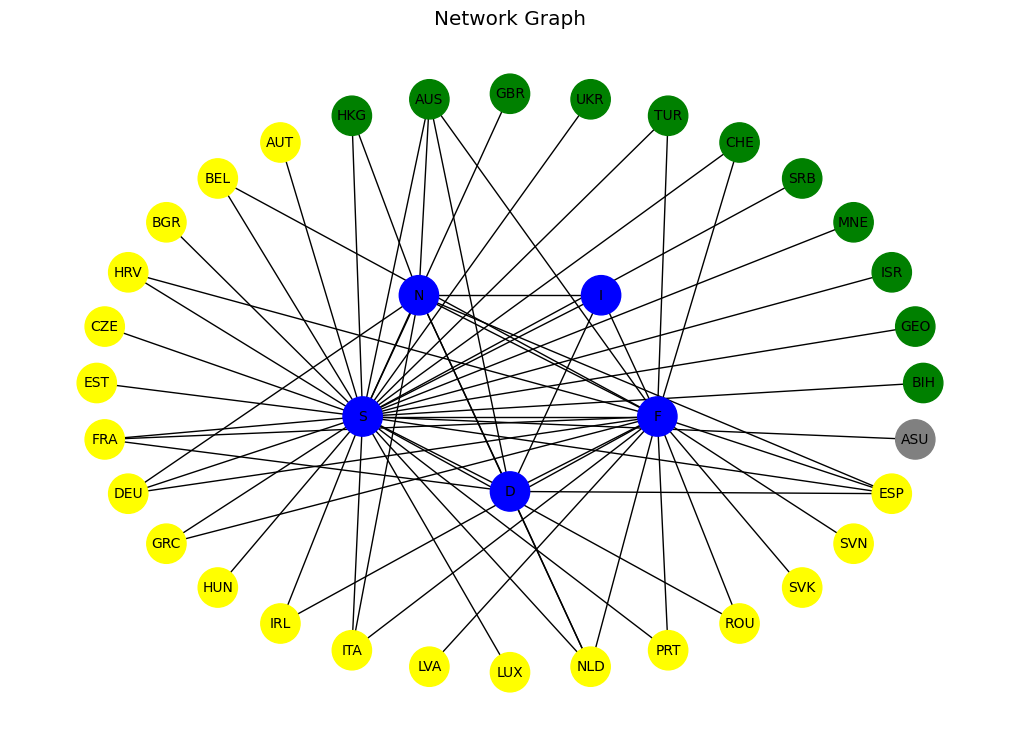

In [54]:
df_network = pd.read_csv("networks_assignment.csv")
df_network.set_index("LABELS", inplace=True)

# Define inner nodes (blue) and outer nodes with their specific color assignments
inner_nodes = ['D', 'F', 'I', 'N', 'S']
green_nodes = ['BIH', 'GEO', 'ISR', 'MNE', 'SRB', 'CHE', 'TUR', 'UKR', 'GBR', 'AUS', 'HKG', 'USA']
yellow_nodes = ['AUT', 'BEL', 'BGR', 'HRV', 'CZE', 'EST', 'FRA', 'DEU', 'GRC', 'HUN', 'IRL', 'ITA',
                'LVA', 'LUX', 'NLD', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP']

# Determine outer nodes: all columns in the CSV that are not inner nodes
all_net_nodes = list(df_network.columns)
outer_nodes = [node for node in all_net_nodes if node not in inner_nodes]

# Build the graph
G = nx.Graph()

# Add inner nodes (color blue)
for node in inner_nodes:
    G.add_node(node, color='blue')

# Add outer nodes with their designated colors
for node in outer_nodes:
    if node in green_nodes:
        color = 'green'
    elif node in yellow_nodes:
        color = 'yellow'
    else:
        color = 'gray'
    G.add_node(node, color=color)

# Add edges: for each inner node, add an edge to any node where the CSV value > 0
for inner in inner_nodes:
    for node in df_network.columns:
        if df_network.loc[inner, node] > 0:
            G.add_edge(inner, node)

# Set positions for nodes
pos = {}
R_inner = 1.5  # radius for inner nodes
R_outer = 4.0  # radius for outer nodes

# Position inner nodes (arranged as a pentagon)
num_inner = len(inner_nodes)
for i, node in enumerate(inner_nodes):
    angle = -math.pi/2 + 2 * math.pi * i / num_inner
    pos[node] = (R_inner * math.cos(angle), R_inner * math.sin(angle))

# Group outer nodes by color. We'll use a custom order:
# green first, then yellow, then gray.
order = {"green": 0, "yellow": 1, "gray": 2}
outer_nodes_sorted = sorted(outer_nodes, key=lambda x: order.get(G.nodes[x]['color'], 3))

num_outer = len(outer_nodes_sorted)
# Position outer nodes evenly on a circle using the sorted order
for i, node in enumerate(outer_nodes_sorted):
    angle = 2 * math.pi * i / num_outer
    pos[node] = (R_outer * math.cos(angle), R_outer * math.sin(angle))

# Draw the network graph
plt.figure(figsize=(10, 7))
node_colors = [G.nodes[node]['color'] for node in G.nodes()]
# Increase node_size to make the circles larger
nx.draw(G, pos, with_labels=True, node_color=node_colors, font_size=10, node_size=800)
plt.title("Network Graph")
plt.show()


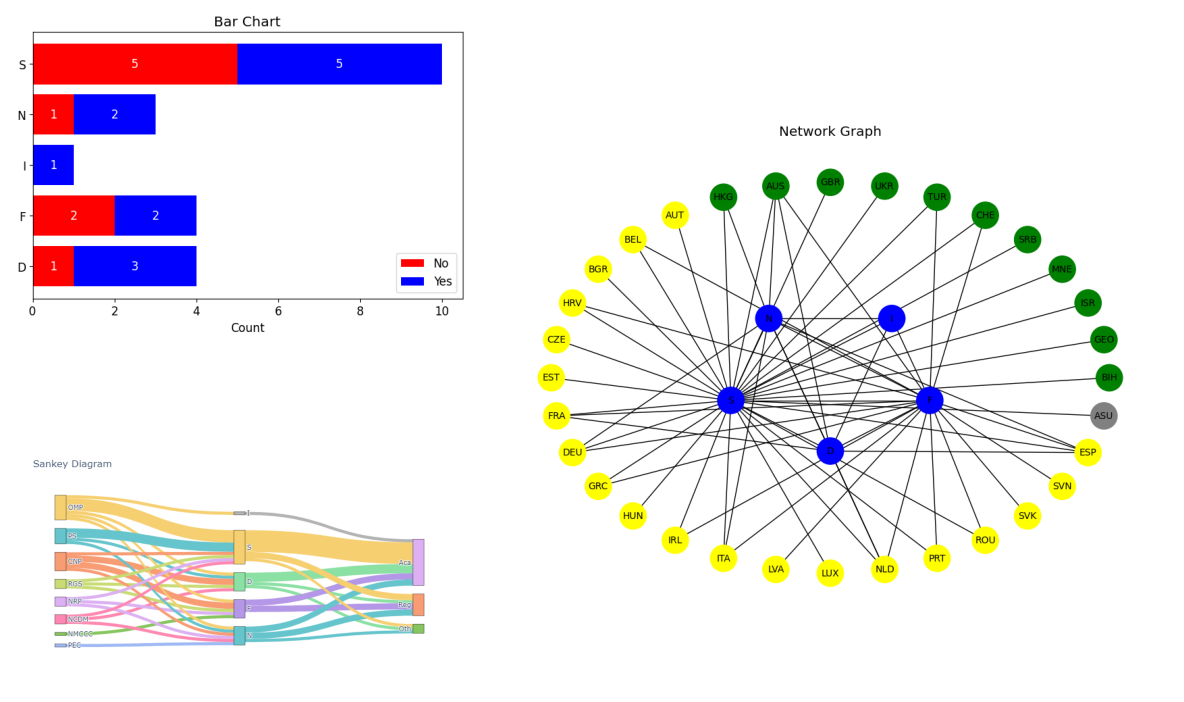

In [56]:
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[4, 6])

ax_bar = fig.add_subplot(gs[0, 0])
ax_sankey = fig.add_subplot(gs[1, 0])
ax_network = fig.add_subplot(gs[:, 1])  # spans both rows in column 1

# Load the individual PNG files
img_bar = mpimg.imread("bar_chart.png")
img_sankey = mpimg.imread("sankey_diagram.png")
img_network = mpimg.imread("network_graph.png")

# Display the Horizontal Stacked Bar Chart in the top left subplot
ax_bar.imshow(img_bar)
ax_bar.axis('off')  # Hide axes

# Display the Sankey Diagram in the bottom left subplot
ax_sankey.imshow(img_sankey)
ax_sankey.axis('off')

# Display the Network Graph in the right subplot
ax_network.imshow(img_network)
ax_network.axis('off')

# Adjust layout to reduce whitespace
plt.tight_layout()

# Save the collated figure as a PNG (deliverable 3)
plt.savefig("collated_graphs.png", dpi=300, bbox_inches='tight')
plt.show()